In [1]:
import calendar
import datetime as dt
import gmaps
import matplotlib.pyplot as plt
import numpy    as np
import os.path
import pandas   as pd
import random   as rand
import seaborn  as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# configure dataset file paths
fulldata2015_filepath = '../../data/raw/wroclawski-rower-miejski/wypozyczenia_wrm-sezon2015.xlsx'
fulldata2016_filepath = '../../data/raw/wroclawski-rower-miejski/wypozyczenia_wrm-sezon2016.xlsx'
bikestations_filepath = '../../data/raw/wroclawski-rower-miejski/transport_stacje_wrm.xlsx'

# configure Google API
with open('GOOGLE_API_KEY.txt', 'r') as file:
    google_API_Key=file.read()

gmaps.configure(api_key=google_API_Key)

In [3]:
rentals2015_df_orig = pd.read_excel(fulldata2015_filepath)
rentals2016_df_orig = pd.read_excel(fulldata2016_filepath)

In [4]:
# A workaround to get fresh data and not to be forced to load the data file again (takes time!)
rentals2015_df = rentals2015_df_orig.copy()
rentals2016_df = rentals2016_df_orig.copy()

# Data cleaning

### Records with 0s of bike rental time length

In [5]:
print("Number of rentals (in 2015) with duration 0 seconds: {}".format(len(rentals2015_df[ rentals2015_df["Data zwrotu"] == rentals2015_df["Data wynajmu"] ])))
print("Number of rentals (in 2016) with duration 0 seconds: {}".format(len(rentals2016_df[ rentals2016_df["Data zwrotu"] == rentals2016_df["Data wynajmu"] ])))

# Rentals with duration 0 seconds are considered as incorrect, thus will be deleted
rentals2015_df.drop(rentals2015_df[ rentals2015_df["Data zwrotu"] == rentals2015_df["Data wynajmu"] ].index, inplace=True)
rentals2016_df.drop(rentals2016_df[ rentals2016_df["Data zwrotu"] == rentals2016_df["Data wynajmu"] ].index, inplace=True)

print("Data cleaning verification:")
print("Number of rentals (in 2015) with duration 0 seconds: {}".format(len(rentals2015_df[ rentals2015_df["Data zwrotu"] == rentals2015_df["Data wynajmu"] ])))
print("Number of rentals (in 2016) with duration 0 seconds: {}".format(len(rentals2016_df[ rentals2016_df["Data zwrotu"] == rentals2016_df["Data wynajmu"] ])))

Number of rentals (in 2015) with duration 0 seconds: 47
Number of rentals (in 2016) with duration 0 seconds: 176
Data cleaning verification:
Number of rentals (in 2015) with duration 0 seconds: 0
Number of rentals (in 2016) with duration 0 seconds: 0


### One-hour time shift at the end of Daylight Saving Time (DST)

The Daylight Saving Time change took place in Poland on:
* 2015-03-29 (2:00am => 3:00 am)
* 2015-10-25 (3:00am => 2:00 am)
* 2016-03-27 (2:00am => 3:00 am)
* 2016-10-30 (3:00am => 2:00 am)

#### Year 2015

##### 3:00am -> 2:00am

In [6]:
# bikes rented right before time shift from 3:00am  to 2:00am
idx = (rentals2015_df["Data wynajmu"] < '2015-10-25 03:00:00') & \
      (rentals2015_df["Data zwrotu"] < rentals2015_df["Data wynajmu"])
rentals2015_df.loc[idx, :]

,L.p.,Numer roweru,Data wynajmu,Data zwrotu,Stacja wynajmu,Stacja zwrotu
787264,787265,57490,2015-10-25 02:23:55,2015-10-25 02:21:33,Rynek,Dworzec Mikołajów
787266,787267,57257,2015-10-25 02:26:04,2015-10-25 02:21:47,Rynek,Dworzec Mikołajów
787281,787282,57167,2015-10-25 02:39:30,2015-10-25 02:12:04,Plac Grunwaldzki - Polaka,Świdnicka - Chrobry
787293,787294,57070,2015-10-25 02:59:10,2015-10-25 02:11:12,Plac Uniwersytecki,Sienkiewicza - Piastowska
787294,787295,57427,2015-10-25 02:59:43,2015-10-25 02:07:00,Arkady,Sky Tower


In [7]:
rentals2015_df.loc[idx, ["Data zwrotu"]] = rentals2015_df.loc[idx, ["Data zwrotu"]].apply(lambda x: x + dt.timedelta(hours=1))

print("Data cleaning verification:")
print("Number of falsy records: {}".format(len(rentals2015_df[ (rentals2015_df["Data wynajmu"] < '2015-10-25 03:00:00') & 
                                                               (rentals2015_df["Data zwrotu"] < rentals2015_df["Data wynajmu"]) ])))

Data cleaning verification:
Number of falsy records: 0


In [8]:
# another invalid records
print("Number of falsy records: {}".format(len(rentals2015_df[ rentals2015_df["Data zwrotu"] < rentals2015_df["Data wynajmu"] ])))

Number of falsy records: 0


#### Year 2016

##### 3:00am -> 2:00am

In [9]:
# bikes rented right before time shift from 3:00am  to 2:00am
idx = (rentals2016_df["Data wynajmu"] > '2016-10-30 00:00:00') & \
      (rentals2016_df["Data wynajmu"] < '2016-10-30 03:00:00') & \
      (rentals2016_df["Data zwrotu"] < rentals2016_df["Data wynajmu"])
rentals2016_df.loc[idx, :]

,L.p.,Numer roweru,Data wynajmu,Data zwrotu,Stacja wynajmu,Stacja zwrotu
979885,979886,57378,2016-10-30 02:59:58,2016-10-30 02:05:56,Dworzec Mikołajów,Dworzec Mikołajów
979887,979888,57666,2016-10-30 02:57:10,2016-10-30 02:07:34,Jedności Narodowej - Nowowiejska,Jedności Narodowej - Nowowiejska
979888,979889,57680,2016-10-30 02:56:29,2016-10-30 02:08:54,Jedności Narodowej - Nowowiejska,Jedności Narodowej - Nowowiejska
979889,979890,57783,2016-10-30 02:58:25,2016-10-30 02:14:12,Sienkiewicza - Wyszyńskiego,Sienkiewicza - Wyszyńskiego


In [10]:
rentals2016_df.loc[idx, ["Data zwrotu"]] = rentals2016_df.loc[idx, ["Data zwrotu"]].apply(lambda x: x + dt.timedelta(hours=1))

print("Data cleaning verification:")
print("Number of falsy records: {}".format(len(rentals2016_df.loc[  (rentals2016_df["Data wynajmu"] > '2016-10-30 00:00:00') & \
                                                                    (rentals2016_df["Data wynajmu"] < '2016-10-30 03:00:00') & \
                                                                    (rentals2016_df["Data zwrotu"] < rentals2016_df["Data wynajmu"])  ])))

Data cleaning verification:
Number of falsy records: 0


##### 2:00am -> 3:00am

In [11]:
# bikes rented right before time shift from 2:00am to 3:00am
idx = (rentals2016_df["Data wynajmu"] < '2016-03-27 02:00:00') & (rentals2016_df["Data zwrotu"] > '2016-03-27 03:00:00')
rentals2016_df.loc[idx, :]

,L.p.,Numer roweru,Data wynajmu,Data zwrotu,Stacja wynajmu,Stacja zwrotu
35640,35641,57075,2016-03-27 01:51:31,2016-03-27 03:01:13,Kredka i Ołówek,Kredka i Ołówek
35641,35642,57778,2016-03-27 01:51:21,2016-03-27 03:01:23,Żmigrodzka / Kasprowicza,Żmigrodzka / Kasprowicza
35642,35643,57580,2016-03-27 01:55:16,2016-03-27 03:06:22,Armii Krajowej - Borowska,Armii Krajowej - Borowska


In [12]:
rentals2016_df.loc[idx, ["Data zwrotu"]] = rentals2016_df.loc[idx, ["Data zwrotu"]].apply(lambda x: x + dt.timedelta(hours=-1))

In [13]:
print("Data cleaning verification:")
print("Number of falsy records: {}".format(len(rentals2016_df[ (rentals2016_df["Data wynajmu"] < '2016-03-27 02:00:00') & 
                                                               (rentals2016_df["Data zwrotu"] > '2016-03-27 03:00:00') ])))

Data cleaning verification:
Number of falsy records: 0


In [14]:
# another invalid records
rentals2016_df[ rentals2016_df["Data zwrotu"] <= rentals2016_df["Data wynajmu"] ]

,L.p.,Numer roweru,Data wynajmu,Data zwrotu,Stacja wynajmu,Stacja zwrotu
299038,299039,57222,2016-05-25 14:30:32,2016-05-25 14:30:30,Sky Tower,Sky Tower
725195,725196,57689,2016-08-16 11:00:37,2016-08-16 11:00:33,Powstańców Śląskich - Hallera,Powstańców Śląskich - Hallera
725576,725577,57213,2016-08-16 13:19:26,2016-08-16 13:19:24,Rynek,Rynek


In [15]:
# Rentals with negative duration time are considered as incorrect, thus will be deleted
rentals2016_df.drop(rentals2016_df[ rentals2016_df["Data zwrotu"] <= rentals2016_df["Data wynajmu"] ].index, inplace=True)

print("Data cleaning verification:")
print("Number of falsy records: {}".format(len(rentals2016_df[ rentals2016_df["Data zwrotu"] < rentals2016_df["Data wynajmu"] ])))

Data cleaning verification:
Number of falsy records: 0


# Data Analysis
### Number of available rentals stations in 2015

In [16]:
print("Number of rental stations: {}".format(len(rentals2015_df["Stacja wynajmu"].unique())));

Number of rental stations: 82


### Rental stations - statistics for 2015

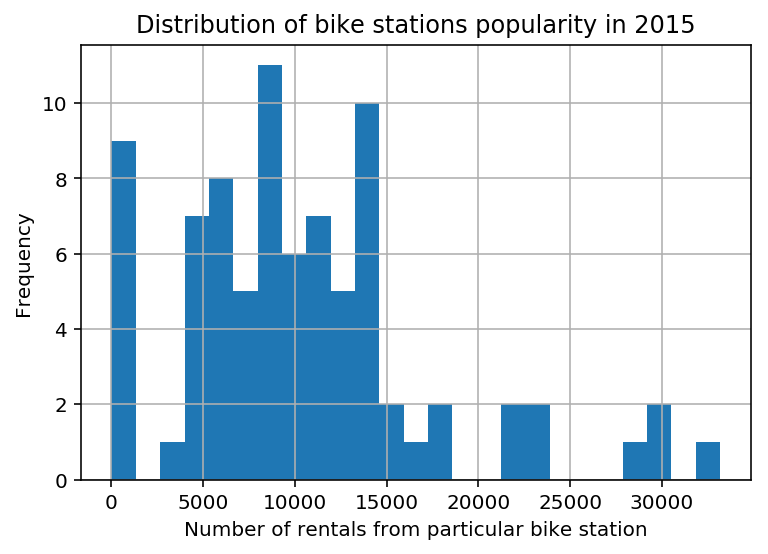

In [17]:
rentals2015_df.groupby(['Stacja wynajmu']).size().hist(bins=25);
plt.title("Distribution of bike stations popularity in 2015");
plt.xlabel("Number of rentals from particular bike station")
plt.ylabel("Frequency")
plt.show();

### 10 most popular bike stations in 2015

In [18]:
rentals2015_df.groupby(['Stacja wynajmu']).size().sort_values(ascending=False).head(10)

Stacja wynajmu
Rynek                            33175
Wita Stwosza - Szewska           30211
Rondo Reagana                    29359
Sky Tower                        28253
Arkady                           22978
Świdnicka - Chrobry              22687
Plac Bema                        21623
Dworzec kolejowy - północ        21363
Powstańców Śląskich - Hallera    18259
Jana Pawła II                    17910
dtype: int64

### 10 least popular bike stations in 2015

In [19]:
print("Actually, it turned out that provided dataset has invalid records:")

df2015 = rentals2015_df.groupby(['Stacja wynajmu'])
df2015_size = df2015.size()
suspected_rentalstations_2015 = list(df2015_size[df2015_size < 10].index)

rentals2015_df[ rentals2015_df['Stacja wynajmu'].isin(suspected_rentalstations_2015) ]

Actually, it turned out that provided dataset has invalid records:


,L.p.,Numer roweru,Data wynajmu,Data zwrotu,Stacja wynajmu,Stacja zwrotu
132014,132015,57481,2015-05-24 23:14:33,2015-05-24 23:37:43,Poznań Główny,Olszewskiego - Spółdzielcza
153397,153398,57010,2015-05-28 17:08:47,2015-05-28 17:23:24,Most Teatralny,Powstańców Śląskich - Hallera
283581,283582,57060,2015-06-19 16:50:54,2015-06-19 16:56:28,Grunwaldzka / Grochowska,Nowowiejska - Prusa
309026,309027,57438,2015-06-25 11:29:32,2015-06-25 11:30:20,Dworzec Głowny PKP,Plac Uniwersytecki
443140,443141,57574,2015-07-23 18:43:40,2015-07-23 18:52:49,Pętla Autobusowa - Dambonia,Świdnicka - Chrobry
534051,534052,57622,2015-08-13 06:45:40,2015-08-13 07:01:13,Ogrody,Powstańców Śląskich - Hallera
534861,534862,57107,2015-08-13 11:14:35,2015-08-13 11:41:35,Ogrody,Świdnicka - Chrobry
661439,661440,57196,2015-09-13 03:51:41,2015-09-13 04:04:14,Plac Wolnosci,Zachodnia - Poznańska
799041,799042,57607,2015-10-30 15:58:49,2015-10-30 16:06:35,Wiejska / Pogodna,Wiejska / Pogodna


Further analysis performed by googling:
* Poznań Główny - rental station in Poznań city
* Most Teatralny - rental station in Poznań city
* Grunwaldzka / Grochowska - rental station in Poznań city
* Dworzec Głowny PKP -> Plac Uniwersytecki - unknown city (inferred from the length of rental time)
* Pętla Autobusowa - Dambonia - rental station in Opole city
* Wiejska / Pogodna	- rental station in Białystok

In [20]:
# drop invalid records
idx = rentals2015_df[ rentals2015_df['Stacja wynajmu'].isin(suspected_rentalstations_2015) ].index
rentals2015_df.drop(idx, inplace=True)

In [21]:
# validation
df2015 = rentals2015_df.groupby(['Stacja wynajmu'])
df2015_size = df2015.size()
print('Number of fauly records: {}'.format(len(df2015_size[df2015_size < 10])))

Number of fauly records: 0


In [22]:
rentals2015_df.groupby(['Stacja wynajmu']).size().sort_values(ascending=False).tail(15)

Stacja wynajmu
Zachodnia - Poznańska             6057
Krucza - Mielecka                 6050
Skarbowców - Wietrzna             5775
Żeromskiego - Kluczborska         5555
Olszewskiego - Spółdzielcza       5536
Krynicka                          5318
Żelazna - Pereca                  5168
Racławicka - Rymarska             5078
Bajana - Szybowcowa               4926
Grochowa - Jemiołowa              4798
Strzegomska - Gubińska            4692
Hallera - Odkrywców               4669
Promenady Business Park           4328
Mickiewicza - pętla tramwajowa    3952
Aleja Bielany                       17
dtype: int64

### 2016

In [23]:
print("Number of rental stations: {}".format(len(rentals2016_df["Stacja wynajmu"].unique())))

Number of rental stations: 76


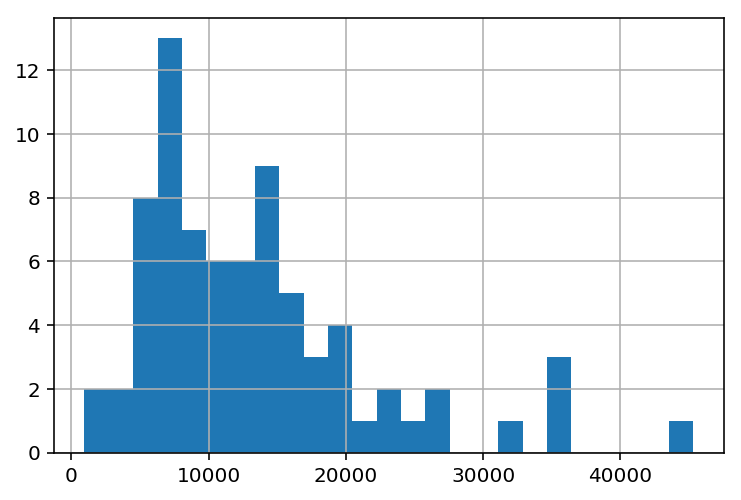

In [24]:
rentals2016_df.groupby(['Stacja wynajmu']).size().hist(bins=25);

In [25]:
rentals2016_df.groupby(['Stacja wynajmu']).size().sort_values(ascending=False).head(10)

Stacja wynajmu
Rynek                            45296
Świdnicka - Chrobry              35606
Rondo Reagana                    35309
Wita Stwosza - Szewska           34837
Sky Tower                        32306
Dworzec kolejowy - północ        26589
Arkady                           26281
Plac Bema                        24346
Hala Targowa                     23891
Powstańców Śląskich - Hallera    23667
dtype: int64

In [26]:
rentals2016_df.groupby(['Stacja wynajmu']).size().sort_values(ascending=False).tail(15)

Stacja wynajmu
Olszewskiego - Spółdzielcza       6676
Żeromskiego - Daszyńskiego        6670
Racławicka - Rymarska             6528
Bajana - Szybowcowa               6228
Zaporoska - Krucza                6050
Grochowa - Jemiołowa              5782
Krucza - Mielecka                 5687
Żeromskiego - Kluczborska         5559
Żelazna - Pereca                  5503
Strzegomska - Gubińska            5072
Mickiewicza - pętla tramwajowa    4718
Hallera - Odkrywców               4300
ul. Ruska                         3417
Aleja Bielany                     1092
Strachocińska / Wieśniacza         950
dtype: int64

## Return bike stations

### 2015

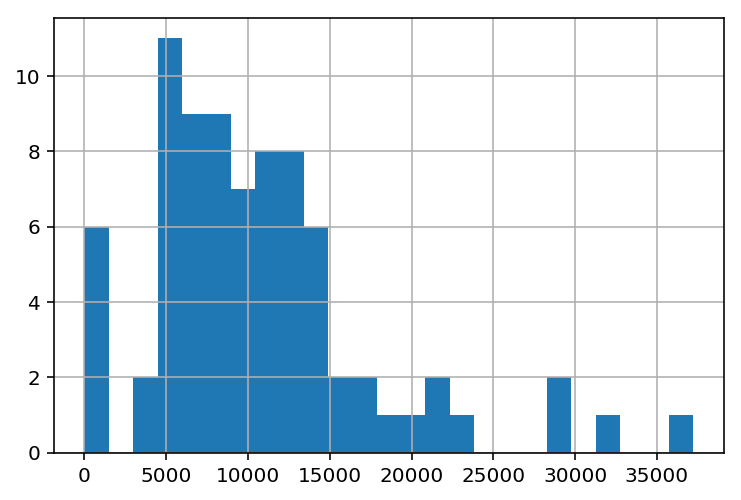

In [27]:
rentals2015_df.groupby(['Stacja zwrotu']).size().hist(bins=25);

In [28]:
rentals2015_df.groupby(['Stacja zwrotu']).size().sort_values(ascending=False).head(10)

Stacja zwrotu
Rynek                            37221
Wita Stwosza - Szewska           31462
Rondo Reagana                    29387
Sky Tower                        28313
Świdnicka - Chrobry              23103
Arkady                           22237
Plac Bema                        21536
Dworzec kolejowy - północ        20626
Powstańców Śląskich - Hallera    18472
Jana Pawła II                    16631
dtype: int64

In [29]:
rentals2015_df.groupby(['Stacja zwrotu']).size().sort_values(ascending=False).tail(10)

Stacja zwrotu
Grochowa - Jemiołowa              4724
Hallera - Odkrywców               4636
Promenady Business Park           4171
Mickiewicza - pętla tramwajowa    4168
Aleja Bielany                       14
Grunwaldzka / Grochowska             1
Dworzec Głowny PKP                   1
Most Teatralny                       1
Plac Wolnosci                        1
Poznań Główny                        1
dtype: int64

In [30]:
df2015 = rentals2015_df.groupby(['Stacja zwrotu'])
df2015_size = df2015.size()
suspected_rentalstations_2015 = list(df2015_size[df2015_size < 10].index)

In [31]:
rentals2015_df[ rentals2015_df['Stacja zwrotu'].isin(suspected_rentalstations_2015) ]

,L.p.,Numer roweru,Data wynajmu,Data zwrotu,Stacja wynajmu,Stacja zwrotu
131847,131848,57481,2015-05-24 22:26:21,2015-05-24 22:46:39,Rynek,Poznań Główny
282706,282707,57060,2015-06-19 14:26:29,2015-06-19 14:50:22,Rondo Reagana,Grunwaldzka / Grochowska
308457,308458,57438,2015-06-25 08:40:22,2015-06-25 09:06:36,Kredka i Ołówek,Dworzec Głowny PKP
518569,518570,57394,2015-08-09 19:14:12,2015-08-09 19:30:35,Hallera - Odkrywców,Most Teatralny
661364,661365,57196,2015-09-13 02:30:07,2015-09-13 02:34:29,Plac Grunwaldzki - Polaka,Plac Wolnosci


In [32]:
# drop invalid records
idx = rentals2015_df[ rentals2015_df['Stacja zwrotu'].isin(suspected_rentalstations_2015) ].index
rentals2015_df.drop(idx, inplace=True)

In [33]:
# validation
df2015 = rentals2015_df.groupby(['Stacja zwrotu'])
df2015_size = df2015.size()
print('Number of fauly records: {}'.format(len(df2015_size[df2015_size < 10])))

Number of fauly records: 0


### 2016

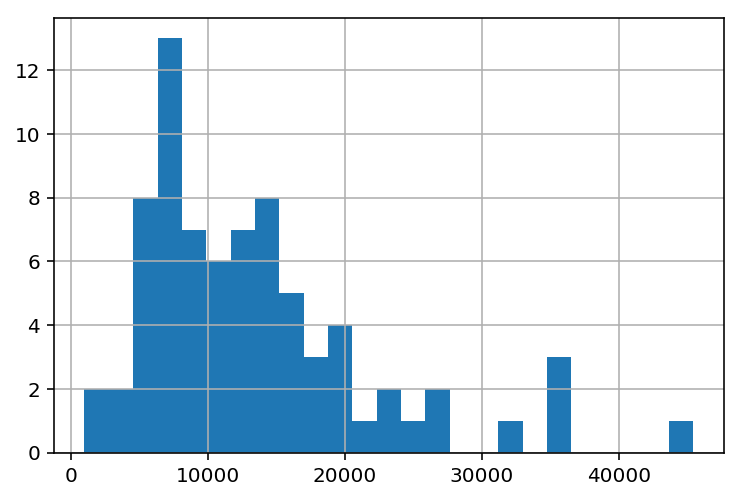

In [34]:
rentals2016_df.groupby(['Stacja zwrotu']).size().hist(bins=25);

In [35]:
rentals2016_df.groupby(['Stacja zwrotu']).size().sort_values(ascending=False).head(10)

Stacja zwrotu
Rynek                            45439
Świdnicka - Chrobry              35627
Rondo Reagana                    35317
Wita Stwosza - Szewska           34903
Sky Tower                        32314
Dworzec kolejowy - północ        26645
Arkady                           26210
Plac Bema                        24365
Hala Targowa                     23831
Powstańców Śląskich - Hallera    23632
dtype: int64

In [36]:
rentals2016_df.groupby(['Stacja zwrotu']).size().sort_values(ascending=False).tail(10)

Stacja zwrotu
Grochowa - Jemiołowa              5809
Krucza - Mielecka                 5696
Żelazna - Pereca                  5521
Żeromskiego - Kluczborska         5513
Strzegomska - Gubińska            5099
Mickiewicza - pętla tramwajowa    4740
Hallera - Odkrywców               4288
ul. Ruska                         3478
Aleja Bielany                     1084
Strachocińska / Wieśniacza         974
dtype: int64

# Data analysis

## Rental Seasons

In [37]:
def get_season_start_date_and_end_date(df):
    index_first = 0
    index_last  = df.index[-1]

    start_date = df.loc[index_first, "Data wynajmu"].date()
    end_date   = df.loc[index_last, "Data zwrotu"].date()
    return start_date, end_date

rentals2015_start_date, rentals2015_end_date = get_season_start_date_and_end_date(rentals2015_df)
print('Season 2015 started on: ', rentals2015_start_date)
print('Season 2015 ended on:   ', rentals2015_end_date)

rentals2016_start_date, rentals2016_end_date = get_season_start_date_and_end_date(rentals2016_df)
print('Season 2016 started on: ', rentals2016_start_date)
print('Season 2016 ended on:   ', rentals2016_end_date)

Season 2015 started on:  2015-04-28
Season 2015 ended on:    2015-11-30
Season 2016 started on:  2016-03-01
Season 2016 ended on:    2016-11-30


## Number of available bikes

In [38]:
unique_bikes_2015 = len(rentals2015_df["Numer roweru"].unique())
unique_bikes_2016 = len(rentals2016_df["Numer roweru"].unique())

unique_bikes_yoy_2015_2016 = (unique_bikes_2016-unique_bikes_2015)*100/unique_bikes_2015

print('Number of bikes in 2015: {}'.format(unique_bikes_2015))
print('Number of bikes in 2016: {} (change: {:.2f}% year-over-year)'.format(unique_bikes_2016, unique_bikes_yoy_2015_2016))

Number of bikes in 2015: 806
Number of bikes in 2016: 783 (change: -2.85% year-over-year)


**DATA INTERPRETATION**: This is interesting, the numer of bikes that were used in 2016 slightly decreased compared to 2015. City bikes are not popular in Wrocław? Luckily, this is not the downward trend, as the number of bikes increased up to 820 in [2018](https://wroclawskirower.pl/en/).

## Number of rentals

In [39]:
total_rentals_2015 = rentals2015_df.shape[0]
total_rentals_2016 = rentals2016_df.shape[0]

total_rentals_yoy_2015_2016 = (total_rentals_2016-total_rentals_2015)*100/total_rentals_2015

print('Number of all rentals in 2015: {}'.format(total_rentals_2015))
print('Number of all rentals in 2016: {} (change: {:.2f}% year-over-year)'.format(total_rentals_2016, total_rentals_yoy_2015_2016))

Number of all rentals in 2015: 843890
Number of all rentals in 2016: 1017192 (change: 20.54% year-over-year)


## Length of time of bike rental
### 2015

In [40]:
rentals2015_df["Długość wynajmu"] = rentals2015_df["Data zwrotu"] - rentals2015_df["Data wynajmu"]
rentals2015_df["Długość wynajmu"].describe()

count                    843890
mean     0 days 00:16:44.028884
std      0 days 00:44:33.324908
min             0 days 00:00:01
25%             0 days 00:06:38
50%             0 days 00:10:42
75%             0 days 00:15:44
max             5 days 17:26:32
Name: Długość wynajmu, dtype: object

In [41]:
rentals2016_df["Długość wynajmu"] = rentals2016_df["Data zwrotu"] - rentals2016_df["Data wynajmu"]
rentals2016_df["Długość wynajmu"].describe()

count                   1017192
mean     0 days 00:16:02.843418
std      0 days 00:36:38.278202
min             0 days 00:00:01
25%             0 days 00:06:42
50%             0 days 00:10:38
75%             0 days 00:15:30
max            13 days 05:09:11
Name: Długość wynajmu, dtype: object

In [42]:
total_rental_time_2015 = rentals2015_df["Długość wynajmu"].sum()
print("Total rental time in 2015: {}".format(total_rental_time_2015))

Total rental time in 2015: 9806 days 14:18:55


In [43]:
total_rental_time_2016 = rentals2016_df["Długość wynajmu"].sum()
total_rental_time_yoy_2015_2016 = (total_rental_time_2016.total_seconds()-total_rental_time_2015.total_seconds())*100/total_rental_time_2015.total_seconds()
print("Total rental time in 2016: {} (change: {:.2f}% year-over-year)".format(total_rental_time_2016, total_rental_time_yoy_2015_2016))

Total rental time in 2016: 11335 days 14:37:03 (change: 15.59% year-over-year)


In [44]:
def get_percentile_when_grace_period_reached(data):
    grace_period = 20*60         # first 20 minutes of rental time is free
    percentile = 1
    val = 0
    while val <= grace_period:
        if (percentile == 100):
            break;
        percentile += 1
        val = np.percentile(data, percentile, axis=0)
        #print('percentile: {}, value: {}'.format(percentile, val))
    return percentile-1

percentile_2015 = get_percentile_when_grace_period_reached(rentals2015_df["Długość wynajmu"].dt.total_seconds().values)
percentile_2016 = get_percentile_when_grace_period_reached(rentals2016_df["Długość wynajmu"].dt.total_seconds().values)
        
print("In 2015, {}% of users rented bike for max 20 minutes.".format(percentile_2015))
print("In 2016, {}% of users rented bike for max 20 minutes.".format(percentile_2016))

In 2015, 85% of users rented bike for max 20 minutes.
In 2016, 86% of users rented bike for max 20 minutes.


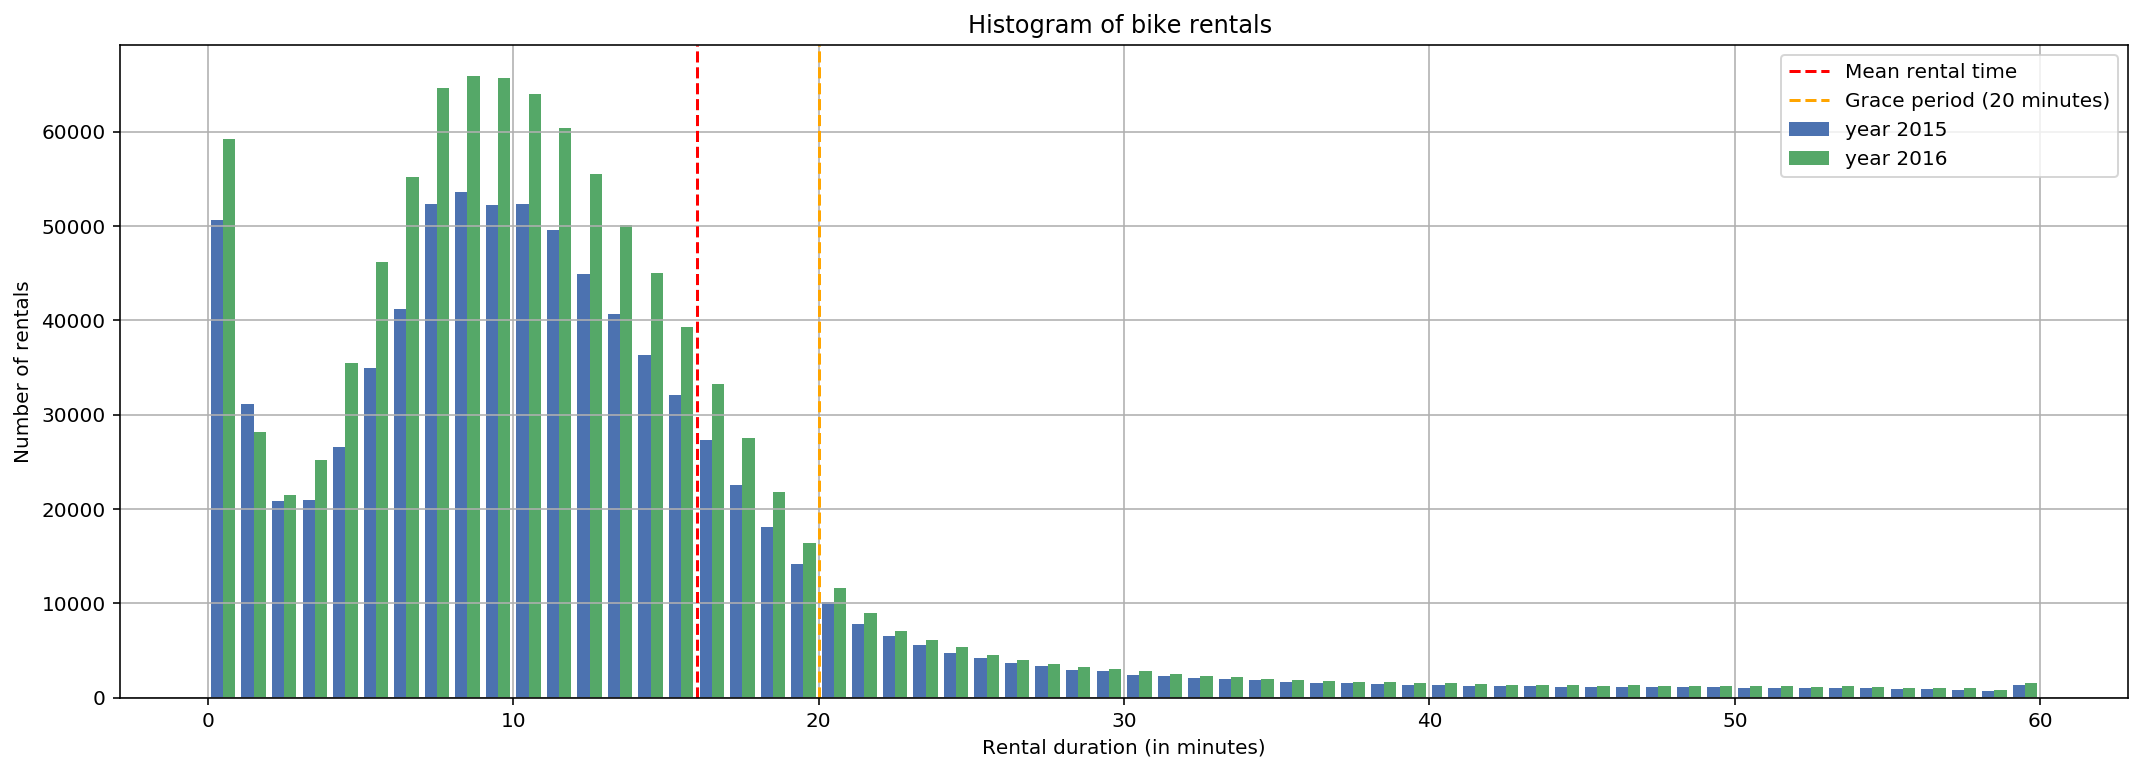

In [45]:
x_2015 = rentals2015_df["Długość wynajmu"].dt.total_seconds().values // 60 # in minutes
x_2016 = rentals2016_df["Długość wynajmu"].dt.total_seconds().values // 60 # in minutes

hours_threshold = 1
x_2015_trimmed = x_2015[ np.where(x_2015 <= hours_threshold*60) ] 
x_2016_trimmed = x_2016[ np.where(x_2016 <= hours_threshold*60) ]


plt.figure(figsize=(18,6))
plt.style.use('seaborn-deep')
plt.hist([x_2015_trimmed, x_2016_trimmed], 
         bins=hours_threshold*60, 
         label=['year 2015', 'year 2016']);
plt.axvline(rentals2016_df["Długość wynajmu"].describe()[1].total_seconds() // 60,
           linestyle='dashed',
           color='red',
           label='Mean rental time')

plt.axvline(20,
           linestyle='dashed',
           color='orange',
           label='Grace period (20 minutes)')

plt.title("Histogram of bike rentals ")
plt.xlabel("Rental duration (in minutes)")
plt.ylabel("Number of rentals")
plt.legend()
plt.grid(True)
plt.show()

**DATA INTERPRETATION**
* Average duration for bike rental is approx. 16 minutes, but usually people rent bikes for around 10.5 minutes.
* 85% of all rentals in 2015, and 86% in 2016 were free of charge (85% in 2015, 86% in 2016).

### Rentals made by early adopters

Assumption: Rentals with duration less that 1 minute as considered to be test rides made by early adopters.

In [46]:
test_rentals_2015_idx = rentals2015_df[ (rentals2015_df["Długość wynajmu"] < '00:01:00')]
print('Number of test rides in 2015: {} ({:.2f}% of all).'.format(len(test_rentals_2015_idx), len(test_rentals_2015_idx)*100 / total_rentals_2015))

test_rentals_2016_idx = rentals2016_df[ (rentals2016_df["Długość wynajmu"] < '00:01:00')]
print('Number of test rides in 2016: {} ({:.2f}% of all).'.format(len(test_rentals_2016_idx), len(test_rentals_2016_idx)*100 / total_rentals_2016))

Number of test rides in 2015: 50654 (6.00% of all).
Number of test rides in 2016: 59278 (5.83% of all).


### Bikes rental over time

In [47]:
# convert data into time series (time as index)
rentals2015_ts = pd.DataFrame(index = rentals2015_df["Data wynajmu"], 
                              columns = ["Count"], 
                              data=np.ones(rentals2015_df.shape[0]))
rentals2016_ts = pd.DataFrame(index = rentals2016_df["Data wynajmu"], 
                              columns = ["Count"], 
                              data=np.ones(rentals2016_df.shape[0]))

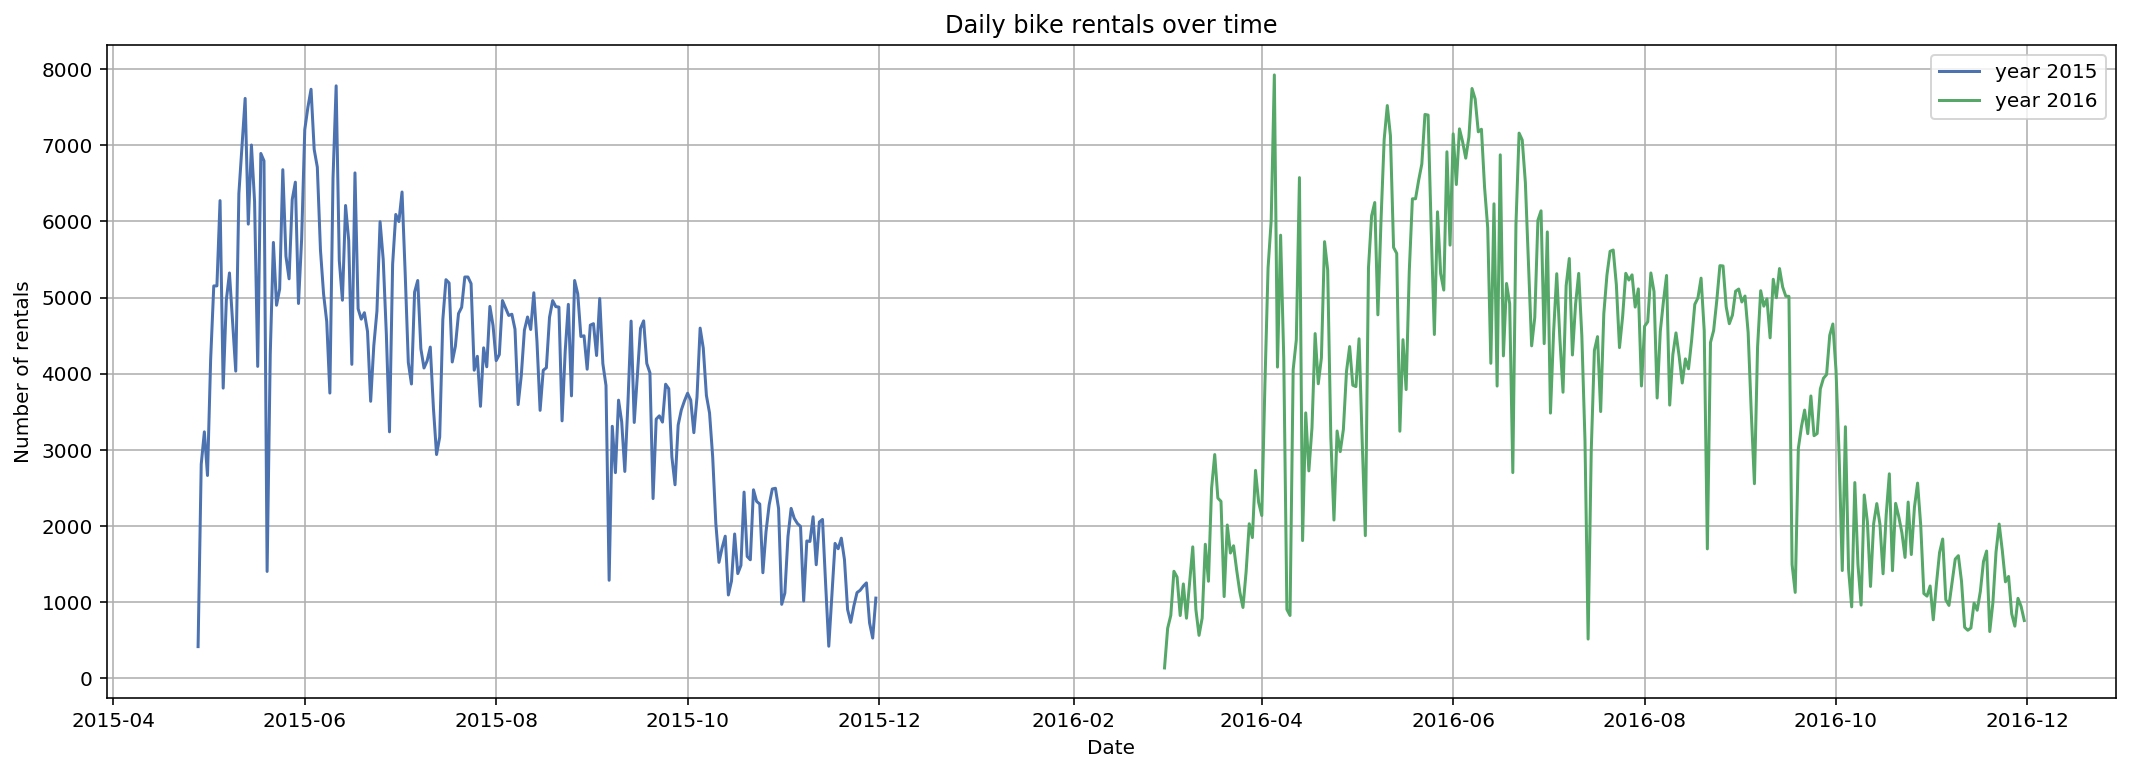

In [48]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(rentals2015_ts.resample("D").count(), label='year 2015');
ax.plot(rentals2016_ts.resample("D").count(), label='year 2016')

ax.set_title("Daily bike rentals over time")
ax.set_xlabel("Date")
ax.set_ylabel("Number of rentals");
ax.legend()
ax.grid(True)

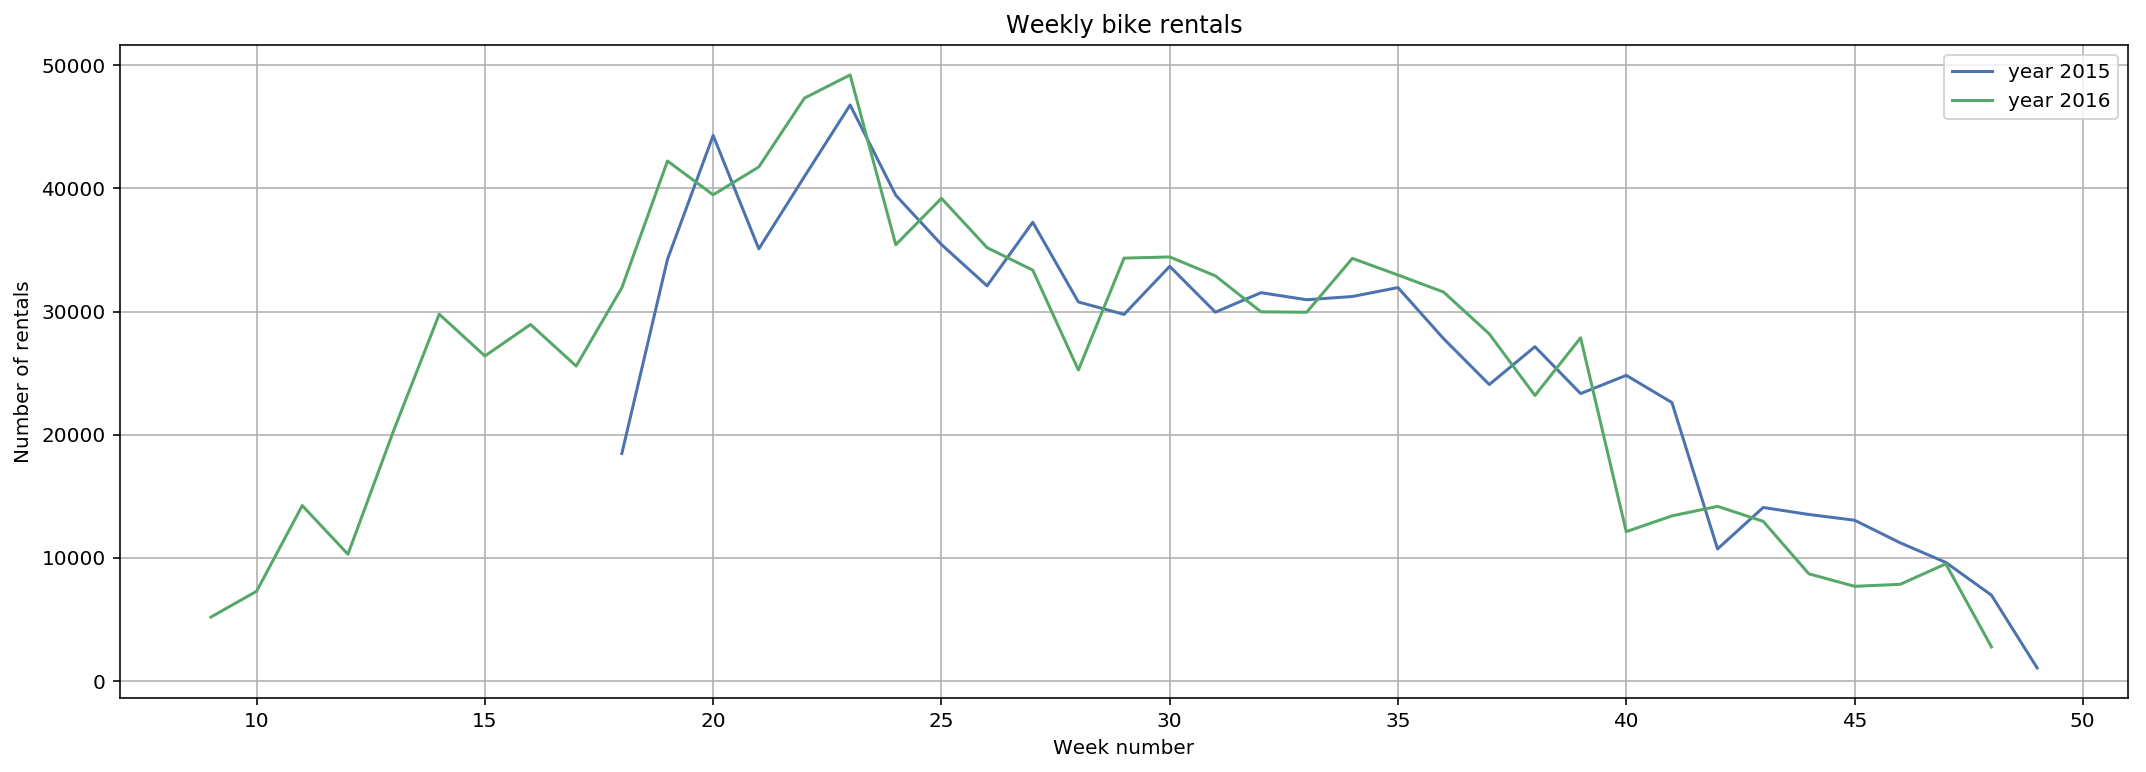

In [49]:
df2015 = rentals2015_ts.resample("W").count()
df2016 = rentals2016_ts.resample("W").count()

fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df2015.index.week, df2015["Count"], label='year 2015');
ax.plot(df2016.index.week, df2016["Count"], label='year 2016')

ax.set_title("Weekly bike rentals")
ax.set_xlabel("Week number")
ax.set_ylabel("Number of rentals");
ax.legend()
ax.grid(True)

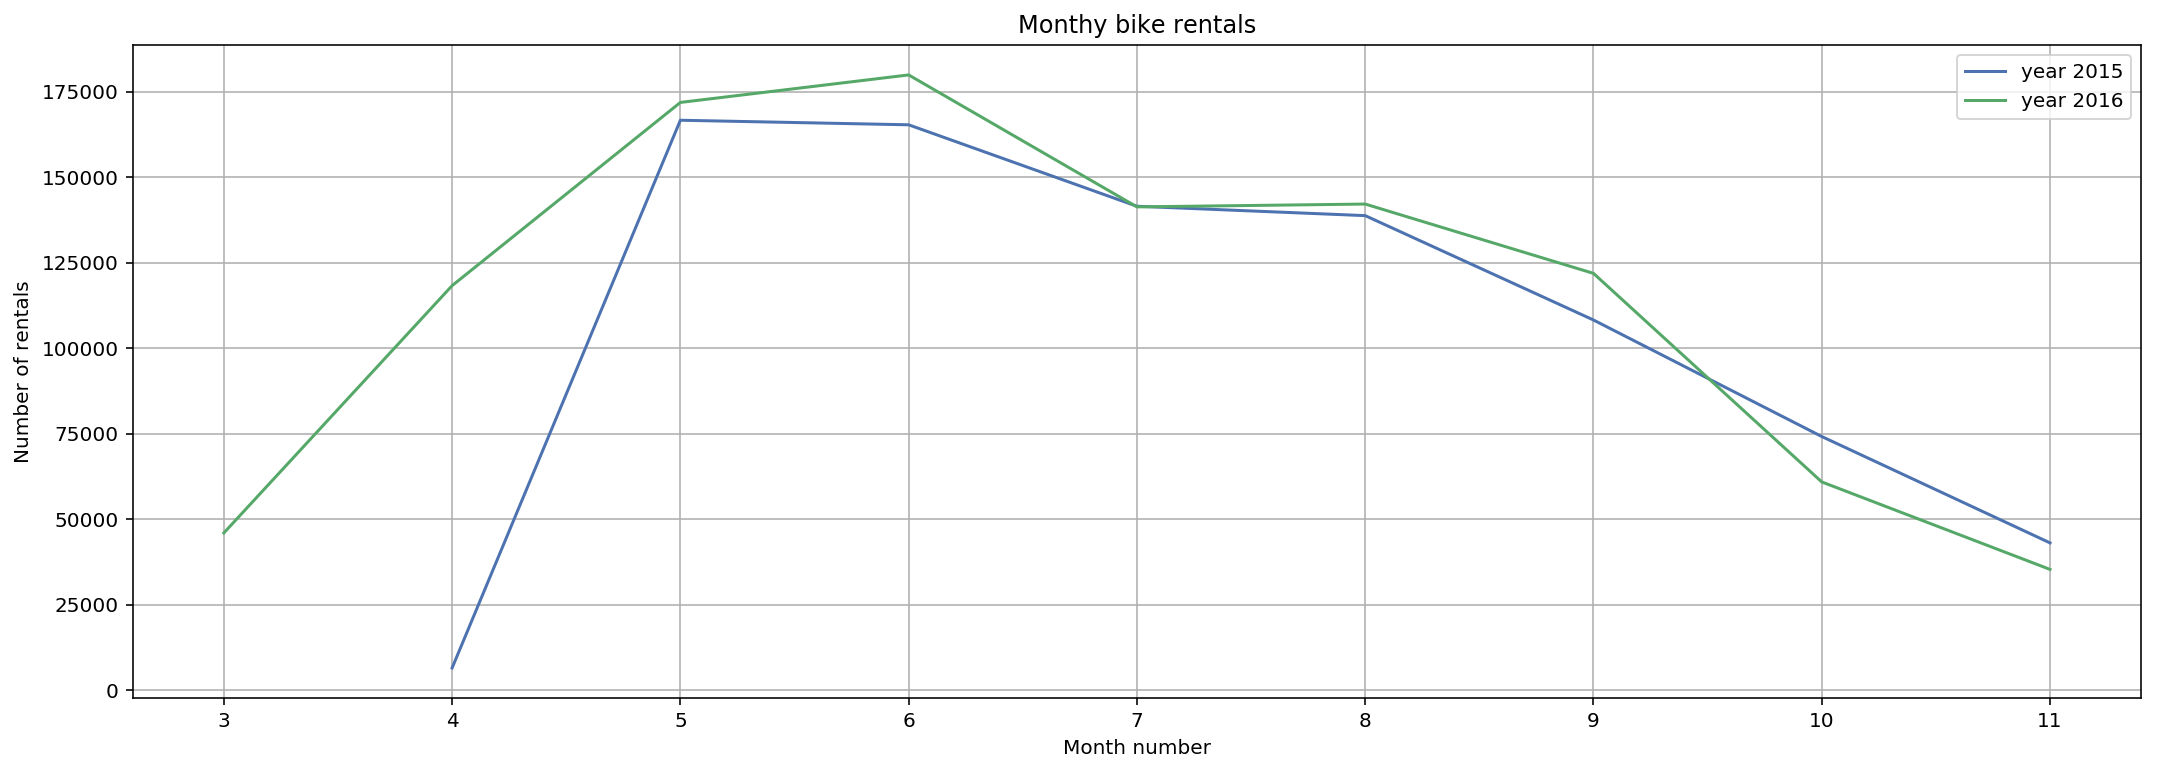

In [50]:
df2015 = rentals2015_ts.resample("M").count()
df2016 = rentals2016_ts.resample("M").count()

fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df2015.index.month, df2015["Count"], label='year 2015');
ax.plot(df2016.index.month, df2016["Count"], label='year 2016')

ax.set_title("Monthy bike rentals")
ax.set_xlabel("Month number")
ax.set_ylabel("Number of rentals");
ax.legend()
ax.grid(True)

Year 2015, daily bike rentals, mean: 3888.89, std: 1686.34
Year 2016, daily bike rentals, mean: 3698.88, std: 1956.01


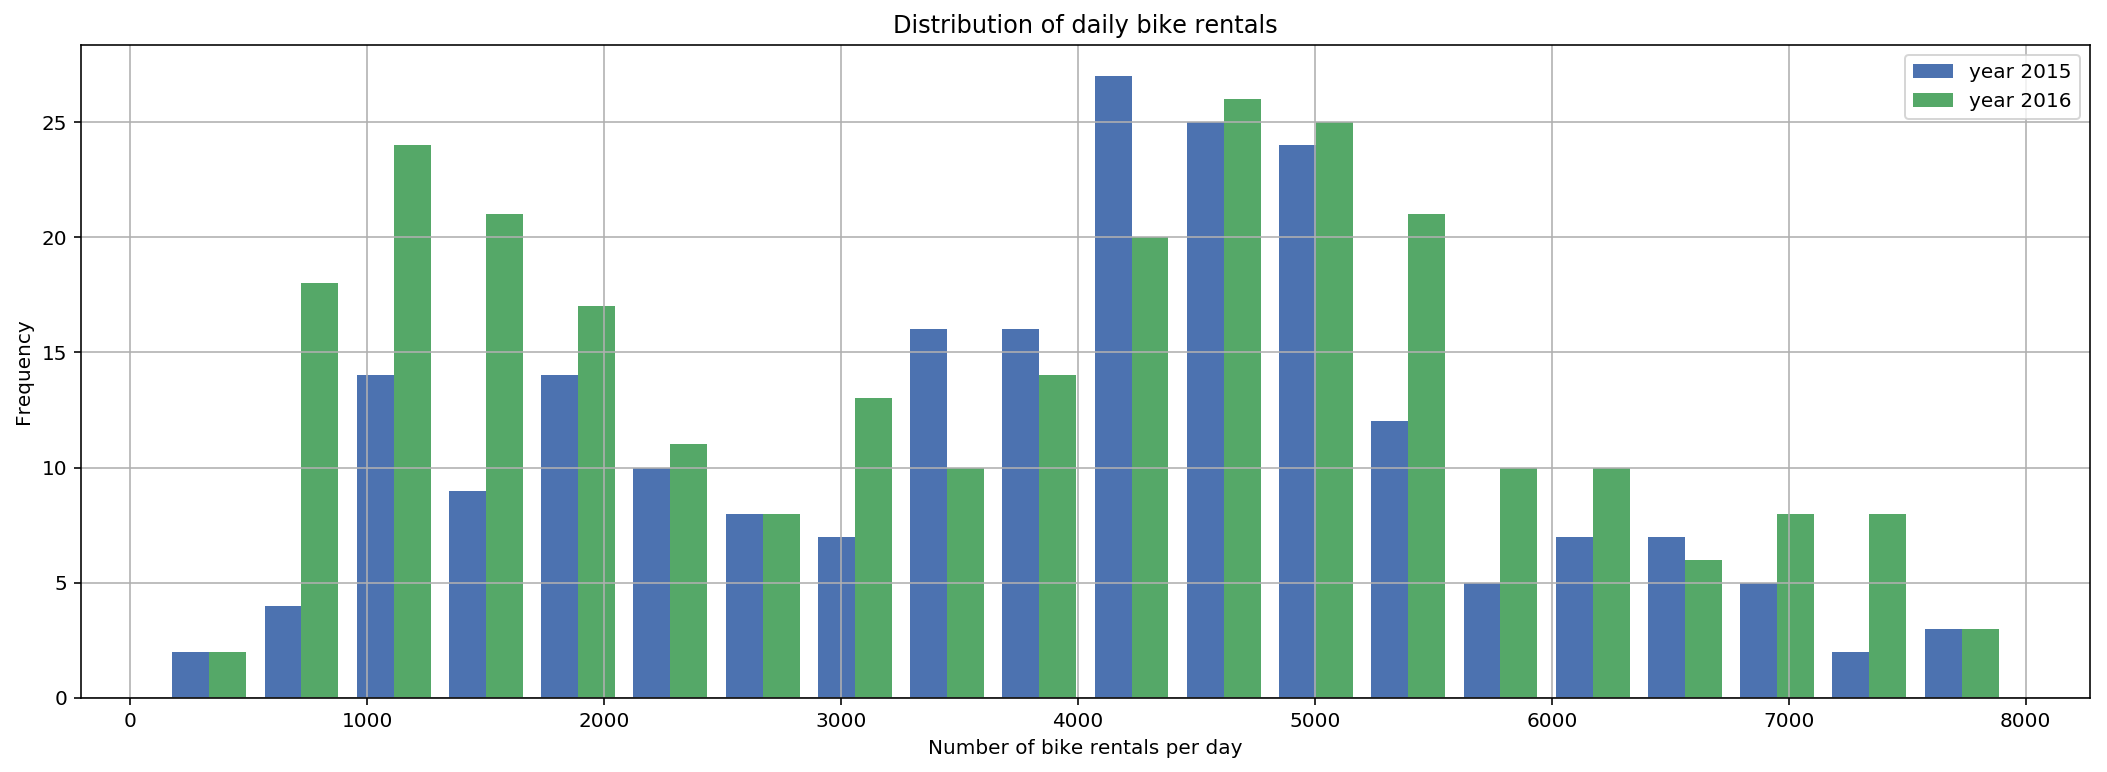

In [51]:
df2015 = rentals2015_ts.resample("D").count()["Count"].values
df2016 = rentals2016_ts.resample("D").count()["Count"].values

print("Year 2015, daily bike rentals, mean: {:.2f}, std: {:.2f}".format(df2015.mean(), df2015.std()))
print("Year 2016, daily bike rentals, mean: {:.2f}, std: {:.2f}".format(df2016.mean(), df2016.std()))

fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1, 1, 1)
ax.hist(x = [df2015, df2016], bins = 20, label=['year 2015', 'year 2016']);

ax.set_title("Distribution of daily bike rentals")
ax.set_xlabel("Number of bike rentals per day")
ax.set_ylabel("Frequency");
ax.legend()
ax.grid(True)

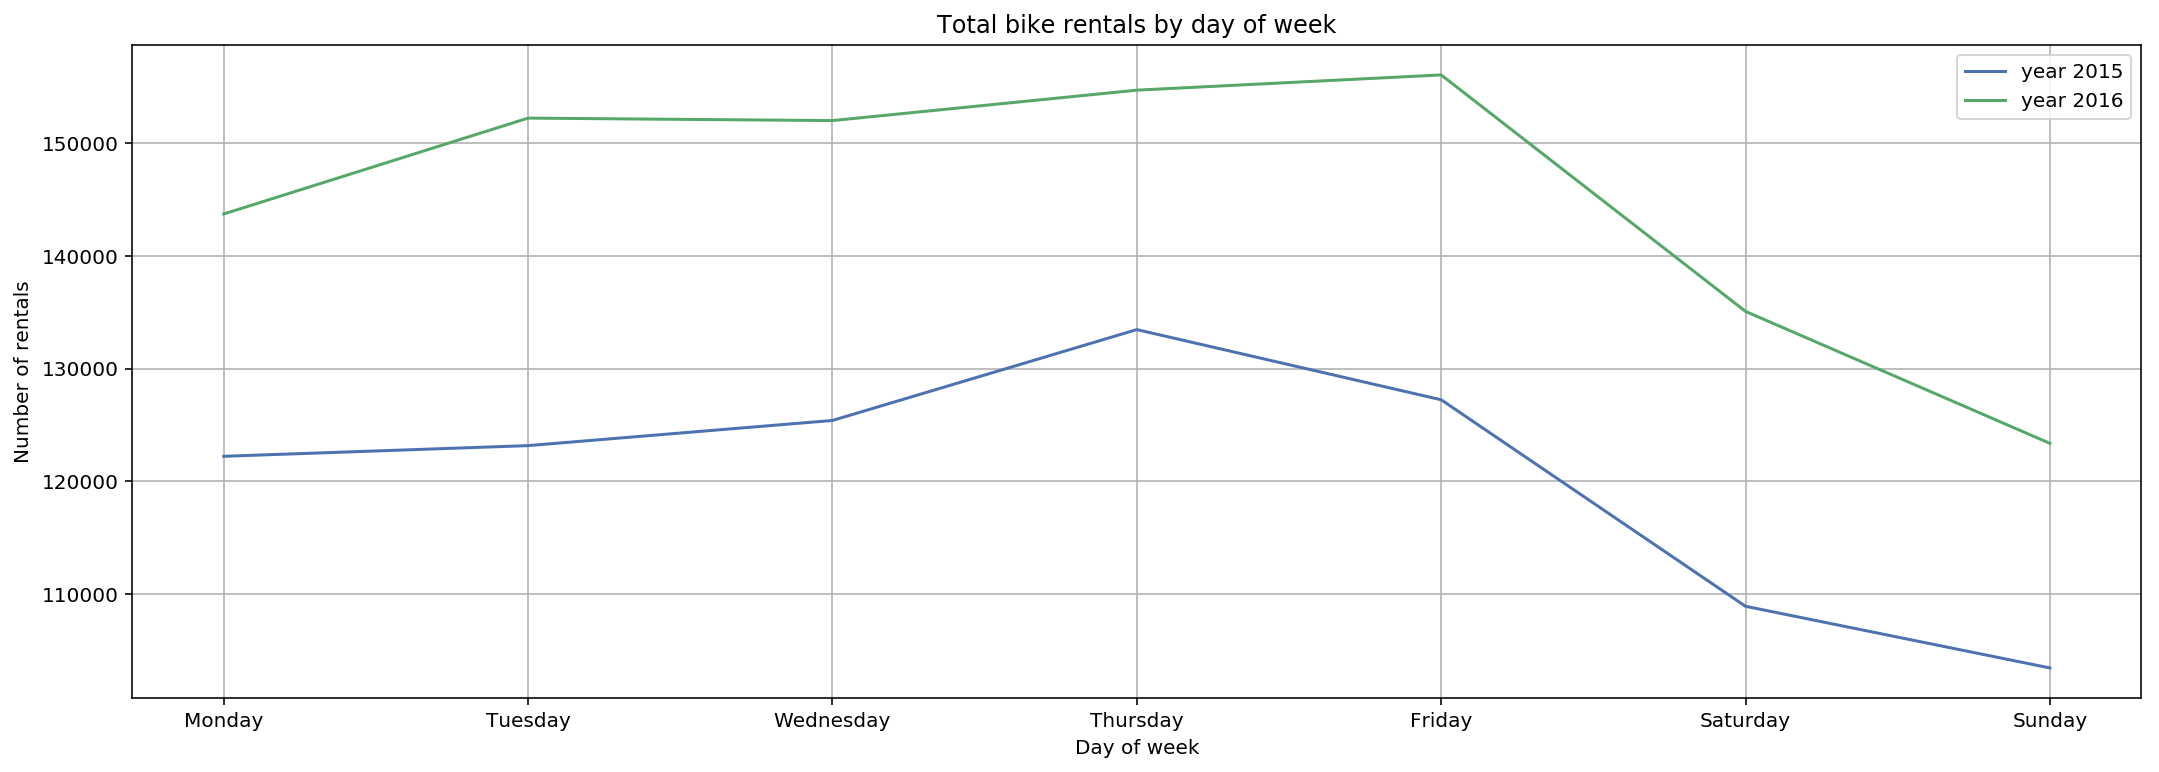

In [52]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(rentals2015_ts.groupby(rentals2015_ts.index.weekday)['Count'].sum(), label='year 2015');
ax.plot(rentals2016_ts.groupby(rentals2016_ts.index.weekday)['Count'].sum(), label='year 2016');

ax.set_title("Total bike rentals by day of week")
ax.set_xlabel("Day of week")
ax.set_ylabel("Number of rentals");
ax.set_xticklabels([''] + list(calendar.day_name))
ax.legend()
ax.grid(True)

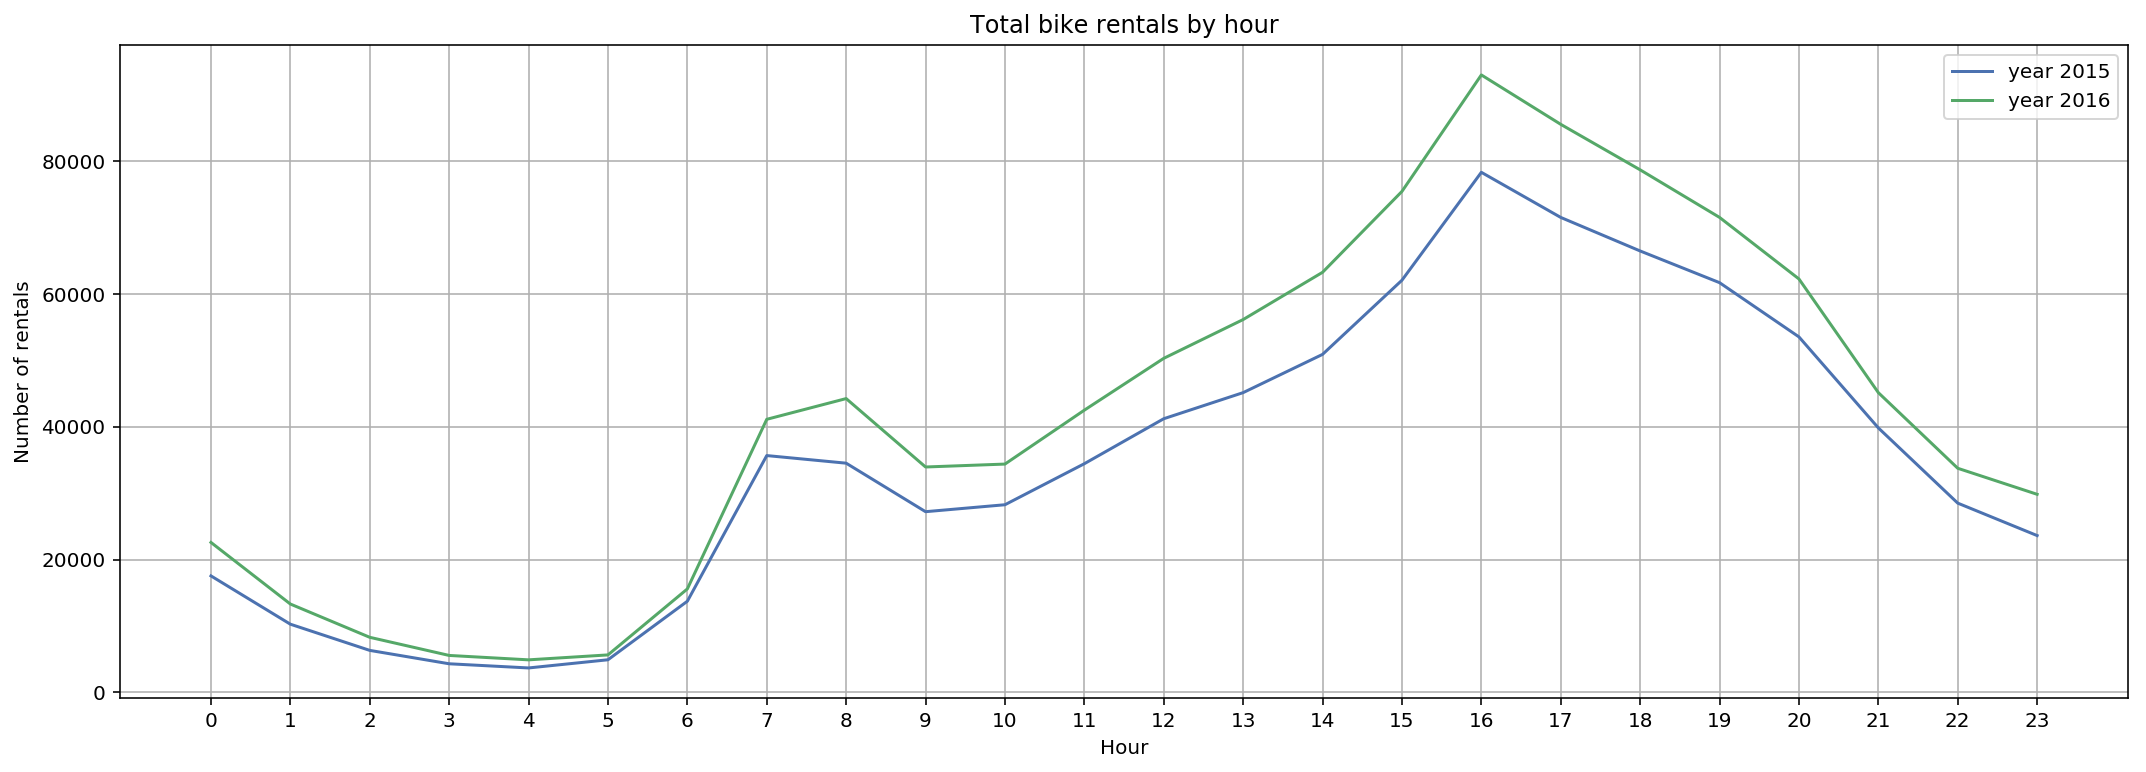

In [53]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(rentals2015_ts.groupby(rentals2015_ts.index.hour)['Count'].sum(), label='year 2015');
ax.plot(rentals2016_ts.groupby(rentals2016_ts.index.hour)['Count'].sum(), label='year 2016');

ax.set_title("Total bike rentals by hour")
ax.set_xlabel("Hour")
ax.set_ylabel("Number of rentals");
ax.set_xticks(np.arange(0, 24, 1))
ax.legend()
ax.grid(True)

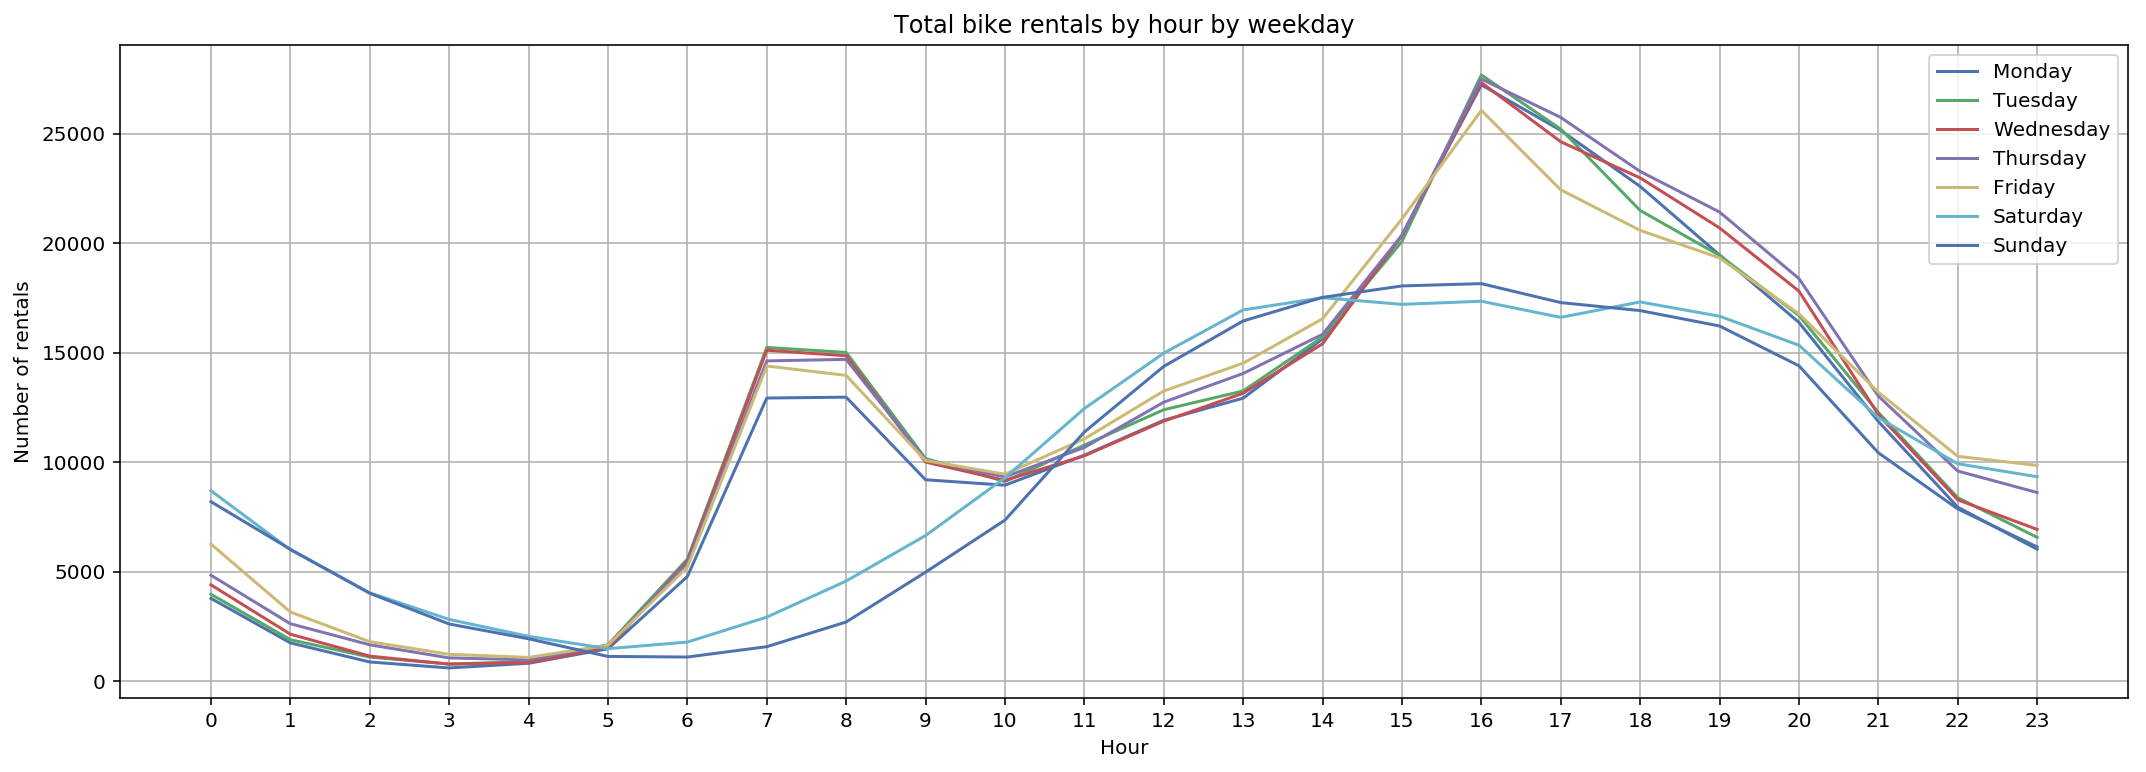

In [54]:
rentals = pd.concat([rentals2015_ts, rentals2016_ts])
rentals["Dzień wynajmu"] = rentals.index.dayofweek       # 0-Monday, 6-Sunday
rentals["Godzina wynajmu"] = rentals.index.hour          # separate column to have a nice index name in the pivot table

df = rentals.pivot_table(index=rentals["Godzina wynajmu"], 
                         columns='Dzień wynajmu', 
                         values='Count',                 # column to aggregate
                         aggfunc='sum')

fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df);
ax.set_title("Total bike rentals by hour by weekday")
ax.set_xlabel("Hour")
ax.set_ylabel("Number of rentals");
ax.set_xticks(np.arange(0, 24, 1))
ax.legend(calendar.day_name)
ax.grid(True)

### Most popular rental stations

In [55]:
# load new dataset
bikestations_df = pd.read_excel(bikestations_filepath)
bikestations_simple = bikestations_df[['Lokalizacja', 'Szer. geograficzna', 'Dł. geograficzna']]

In [56]:
# 10 most popular rental stations in 2015
top10_in_2015 = rentals2015_df.groupby(['Stacja wynajmu']) \
                              .size() \
                              .sort_values(ascending=False) \
                              .reset_index(name='Ilość wypożyczeń') \
                              .head(10)
top10_in_2015

,Stacja wynajmu,Ilość wypożyczeń
0,Rynek,33174
1,Wita Stwosza - Szewska,30211
2,Rondo Reagana,29358
3,Sky Tower,28253
4,Arkady,22978
5,Świdnicka - Chrobry,22687
6,Plac Bema,21623
7,Dworzec kolejowy - północ,21363
8,Powstańców Śląskich - Hallera,18259
9,Jana Pawła II,17910


In [57]:
# 10 most popular rental stations in 2016
top10_in_2016 = rentals2016_df.groupby(['Stacja wynajmu']) \
                              .size() \
                              .sort_values(ascending=False) \
                              .reset_index(name='Ilość wypożyczeń') \
                              .head(10)
top10_in_2016

,Stacja wynajmu,Ilość wypożyczeń
0,Rynek,45296
1,Świdnicka - Chrobry,35606
2,Rondo Reagana,35309
3,Wita Stwosza - Szewska,34837
4,Sky Tower,32306
5,Dworzec kolejowy - północ,26589
6,Arkady,26281
7,Plac Bema,24346
8,Hala Targowa,23891
9,Powstańców Śląskich - Hallera,23667


The list of top 10 most popular bike stations for 2015 and 2016 years seem to be constant. Although we can notice some changes in the rankings, basically 9 out of 10 most popular bike stations in 2015 were also popular in the next year. 

In [58]:
def create_marker_locations(data):
    marker_locations = [(row["Szer. geograficzna"], row["Dł. geograficzna"]) for index, row in data.iterrows()]
    return marker_locations

marker_info_box_template = \
"""
<dl>
<dt>Stacja wynajmu:</dt><dd>{Stacja wynajmu}</dd>
<dt>Ilość wypożyczeń:</dt><dd>{Ilość wypożyczeń}</dd>
</dl>
"""

def create_bike_stations_info(data):
    bike_stations_info = [marker_info_box_template.format(**row) for index, row in data.iterrows()]
    return bike_stations_info

In [59]:
top10_in_2016_with_gps = pd.merge(top10_in_2016, bikestations_simple, 
                                  left_on="Stacja wynajmu", right_on="Lokalizacja")
top10_in_2016_with_gps.drop(columns="Lokalizacja", inplace=True)

marker_locations = create_marker_locations(top10_in_2016_with_gps)
bike_stations_info = create_bike_stations_info(top10_in_2016_with_gps)

# show bike stations on map
fig = gmaps.figure()
markers = gmaps.marker_layer(marker_locations, info_box_content=bike_stations_info)
fig.add_layer(markers)
fig # display the figure

Figure(layout=FigureLayout(height='420px'))

### Least popular rental stations

In [60]:
# 10 least popular rental stations in 2015
bottom10_in_2015 = rentals2015_df.groupby(['Stacja wynajmu']) \
                                 .size() \
                                 .sort_values(ascending=False) \
                                 .reset_index(name='Ilość wypożyczeń') \
                                 .tail(10)
bottom10_in_2015

,Stacja wynajmu,Ilość wypożyczeń
64,Krynicka,5318
65,Żelazna - Pereca,5168
66,Racławicka - Rymarska,5078
67,Bajana - Szybowcowa,4926
68,Grochowa - Jemiołowa,4798
69,Strzegomska - Gubińska,4692
70,Hallera - Odkrywców,4668
71,Promenady Business Park,4328
72,Mickiewicza - pętla tramwajowa,3952
73,Aleja Bielany,17


In [61]:
# 10 least popular rental stations in 2016
bottom10_in_2016 = rentals2016_df.groupby(['Stacja wynajmu']) \
                                 .size() \
                                 .sort_values(ascending=False) \
                                 .reset_index(name='Ilość wypożyczeń') \
                                 .tail(10)
bottom10_in_2016

,Stacja wynajmu,Ilość wypożyczeń
66,Grochowa - Jemiołowa,5782
67,Krucza - Mielecka,5687
68,Żeromskiego - Kluczborska,5559
69,Żelazna - Pereca,5503
70,Strzegomska - Gubińska,5072
71,Mickiewicza - pętla tramwajowa,4718
72,Hallera - Odkrywców,4300
73,ul. Ruska,3417
74,Aleja Bielany,1092
75,Strachocińska / Wieśniacza,950


In [62]:
bottom10_in_2016_with_gps = pd.merge(bottom10_in_2016, bikestations_simple, 
                                     left_on="Stacja wynajmu", right_on="Lokalizacja")
bottom10_in_2016_with_gps.drop(columns="Lokalizacja", inplace=True)

marker_locations = create_marker_locations(bottom10_in_2016_with_gps)
bike_stations_info = create_bike_stations_info(bottom10_in_2016_with_gps)

# show bike stations on map
fig = gmaps.figure()
markers = gmaps.marker_layer(marker_locations, info_box_content=bike_stations_info)
fig.add_layer(markers)
fig # display the figure

Figure(layout=FigureLayout(height='420px'))

### Most popular rental stations for given day and hour

In [63]:
rentals = pd.concat([rentals2015_df, rentals2016_df])
rentals["Dzień wynajmu"] = rentals["Data wynajmu"].dt.dayofweek       
rentals["Godzina wynajmu"] = rentals["Data wynajmu"].dt.hour
rentals["Count"] = 1

In [64]:
day = 6 # 0-Monday, 6-Sunday 
the_hour = 16

filtered_df = rentals[ (rentals["Dzień wynajmu"] == day) & (rentals["Godzina wynajmu"] == the_hour) ]
top_df = pd.DataFrame({'Ilość wypożyczeń': filtered_df.groupby(["Stacja wynajmu"])
                                                      .size()
                                                      .sort_values(ascending=False)
                                                      .head(10)}).reset_index()

#print("Most popular bike stations on {}, at {} o'clock:".format(calendar.day_name[day], the_hour))
#print(top_df)

# augment with GPS data
top_df = pd.merge(top_df, bikestations_simple, left_on="Stacja wynajmu", right_on="Lokalizacja")
top_df.drop(columns="Lokalizacja", inplace=True)

marker_locations = create_marker_locations(top_df)
bike_stations_info = create_bike_stations_info(top_df)

# show bike stations on map
fig = gmaps.figure()
markers = gmaps.marker_layer(marker_locations, info_box_content=bike_stations_info)
fig.add_layer(markers)
fig # display the figure

Figure(layout=FigureLayout(height='420px'))

### 10 most popular routes in 2015

In [65]:
top10_routes_in_2015 = \
    rentals2015_df[["Stacja wynajmu", "Stacja zwrotu"]] \
        .groupby(["Stacja wynajmu", "Stacja zwrotu"]) \
        .size() \
        .sort_values(ascending=False) \
        .reset_index() \
        .head(10)

top10_routes_in_2015.rename(columns={0: 'Ilość wypożyczeń'}, inplace=True)
top10_routes_in_2015

,Stacja wynajmu,Stacja zwrotu,Ilość wypożyczeń
0,Sky Tower,Sky Tower,6819
1,Rynek,Rynek,6620
2,Rondo Reagana,Rondo Reagana,5961
3,Wita Stwosza - Szewska,Wita Stwosza - Szewska,5452
4,Arkady,Arkady,5419
5,Plac Bema,Plac Bema,5056
6,Świdnicka - Chrobry,Świdnicka - Chrobry,4535
7,Dworzec kolejowy - północ,Dworzec kolejowy - północ,3803
8,Powstańców Śląskich - Hallera,Powstańców Śląskich - Hallera,3473
9,Plac Grunwaldzki - Polaka,Plac Grunwaldzki - Polaka,3469


Interestingly, 10 most popular routes start and end at the same bike station.

### 10 most popular routes in 2015 with durations >= 5 minutes

In [72]:
idx = rentals2015_df["Długość wynajmu"] >= np.timedelta64(5, 'm')

top10_routes_in_2015 = \
    rentals2015_df.loc[idx, ["Stacja wynajmu", "Stacja zwrotu"]] \
        .groupby(["Stacja wynajmu", "Stacja zwrotu"]) \
        .size() \
        .sort_values(ascending=False) \
        .reset_index() \
        .head(10)

top10_routes_in_2015.rename(columns={0: 'Ilość wypożyczeń'}, inplace=True)
top10_routes_in_2015

,Stacja wynajmu,Stacja zwrotu,Ilość wypożyczeń
0,Rynek,Rynek,2703
1,Rondo Reagana,Rondo Reagana,1950
2,Wita Stwosza - Szewska,Wita Stwosza - Szewska,1816
3,Sky Tower,Sky Tower,1807
4,Politechnika Wrocławska - Gmach Główny,Teki,1752
5,Rondo Reagana,Teki,1710
6,Teki,Politechnika Wrocławska - Gmach Główny,1704
7,Nowowiejska - Wyszyńskiego,Rondo Reagana,1663
8,Plac Bema,Plac Bema,1602
9,Sky Tower,Powstańców Śląskich - Hallera,1577


Interestingly, 5 out of 10 most popular routes for rental duration longer than 5 minutes also start and end at the same bike station.

### 10 most popular routes in 2015 (when rental station is different than return station)

In [67]:
idx = rentals2015_df["Stacja wynajmu"] != rentals2015_df["Stacja zwrotu"]

top10_routes_in_2015 = \
    rentals2015_df.loc[idx, ["Stacja wynajmu", "Stacja zwrotu"]] \
                  .groupby(["Stacja wynajmu", "Stacja zwrotu"]) \
                  .size() \
                  .sort_values(ascending=False) \
                  .reset_index() \
                  .head(10) 
top10_routes_in_2015.rename(columns={0: 'Ilość wypożyczeń'}, inplace=True)
top10_routes_in_2015

,Stacja wynajmu,Stacja zwrotu,Ilość wypożyczeń
0,Politechnika Wrocławska - Gmach Główny,Teki,1758
1,Rondo Reagana,Teki,1720
2,Teki,Politechnika Wrocławska - Gmach Główny,1706
3,Nowowiejska - Wyszyńskiego,Rondo Reagana,1673
4,Sky Tower,Powstańców Śląskich - Hallera,1641
5,Rondo Reagana,Nowowiejska - Wyszyńskiego,1560
6,Rondo Reagana,Kredka i Ołówek,1436
7,Park Południowy - Powstańców Śląskich,Skarbowców - Wietrzna,1420
8,Arkady,Sky Tower,1379
9,Teki,Rondo Reagana,1368


### Visualization - 10 most popular routes in 2015 (when rental station is different than return station)

In [70]:
top10_routes_in_2015_with_gps = pd.merge(top10_routes_in_2015, 
                                         bikestations_simple, 
                                         left_on="Stacja wynajmu", right_on="Lokalizacja")

top10_routes_in_2015_with_gps = pd.merge(top10_routes_in_2015_with_gps, 
                                         bikestations_simple, 
                                         left_on="Stacja zwrotu", right_on="Lokalizacja",
                                         suffixes=('_wynajem', '_zwrot'))

top10_routes_in_2015_with_gps.drop(columns=["Lokalizacja_wynajem", "Lokalizacja_zwrot"], inplace=True)

# show bike stations on map
colors = ['red', 'green', 'blue', 'black', 'white', 'purple', 'yellow', 'teal', 'lime', 'olive']
fig = gmaps.figure()
for index, row in top10_routes_in_2015_with_gps.iterrows():
    from_station = (row["Szer. geograficzna_wynajem"], row["Dł. geograficzna_wynajem"])
    to_station = (row["Szer. geograficzna_zwrot"], row["Dł. geograficzna_zwrot"])
    direction_layer = gmaps.directions_layer(from_station, to_station, 
                                             stroke_color=colors[index], stroke_opacity=0.4,
                                             show_markers=False)
    fig.add_layer(direction_layer)
fig # display the figure

Figure(layout=FigureLayout(height='420px'))

In [71]:
# Extra:
# * nice example of plot analysis https://books.google.pl/books?id=8eZDDwAAQBAJ&pg=PA145&lpg=PA145&dq=ax.set_xticklabels+day+of+week&source=bl&ots=c6VZgG866Y&sig=-oEzqNcqPB1mjeKPtH_KywZMv84&hl=en&sa=X&ved=2ahUKEwj9-d28iqndAhWLlSwKHanpDPsQ6AEwBHoECAYQAQ#v=onepage&q=ax.set_xticklabels%20day%20of%20week&f=false

TODO:
- [x] number of rentals per day/week/month
- [x] number of rentals per day of week
- [x] total ~~average~~ bike rentals by day of week
- [x] number of rentals per hour
- [x] number of rentals per hour and day of week
- [x] most popular bike stations for renting bikes
- ~~most popular bike stations for returning bikes~~
- approx. overall distance travelled by bike
- estimated travel time from one bike station to another.

- DATA AUGMENTATION:
- holidays
- gps distance
- weather